In [10]:
from langchain_google_vertexai import ChatVertexAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate
)

from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain.output_parsers.json import SimpleJsonOutputParser

from typing import List, Tuple

import os
import json
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH = "..\\..\\src\\data\\komus\\dataset.json"

with open(PATH, "r", encoding="UTF-8") as file:
    data = json.load(file)

len(data)

83755

In [2]:
METRICS_CLASSIFY_DATASET_PATH = ".\\metrics_classify_dataset.json"

with open(METRICS_CLASSIFY_DATASET_PATH, "r", encoding="UTF-8") as file:
    metrics_data = json.load(file)

y_true = [item["correct_ans"] for item in metrics_data]

In [3]:
CATEGORIES_PATH = ".\\categories.txt"

with open(CATEGORIES_PATH, "r", encoding="UTF-8") as file:
    categories_array = file.read().splitlines()

categories_txt = "\n".join([f"{i}. {category}" for i, category in enumerate(categories_array, start=1)])
categories_txt

'1. Автозапчасти\n2. Аксессуары для мобильных устройств\n3. Здания и работы по возведению зданий\n4. Игры и игрушки\n5. Изделия готовые, не включенные в другие группировки\n6. Изделия из бумаги и картона\n7. Изделия из дерева, пробки, соломки и материалов для плетения\n8. Изделия из кожи\n9. Изделия из пластмасс\n10. Изделия металлические готовые прочие\n11. Изделия ножевые\n12. Изделия резиновые\n13. Изделия текстильные прочие\n14. Изделия ювелирные, бижутерия и подобные изделия\n15. Инструменты\n16. Инструменты и оборудование\n17. Инструменты музыкальные\n18. Канцелярские товары\n19. Карты и атласы\n20. Компьютеры и периферийное оборудование\n21. Культуры однолетние\n22. Материалы для строительства\n23. Материалы для строительства и ремонта\n24. Материалы лакокрасочные и аналогичные для нанесения покрытий\n25. Материалы растительные: растения живые; луковицы, клубнелуковицы и корневища; отводки и черенки; грибницы\n26. Материалы электромонтажные\n27. Мебель\n28. Металлоконструкции ст

# Utils

In [4]:
def create_model_prompts(system_prompt: str,
                         user_prompt: str) -> ChatPromptTemplate:
    system_prompt = SystemMessagePromptTemplate.from_template(system_prompt)
    user_prompt = HumanMessagePromptTemplate.from_template(user_prompt)
    chat_prompt = ChatPromptTemplate.from_messages(
        [system_prompt,
         user_prompt]
    )
    return chat_prompt

# Model

In [5]:
from langchain_openai import ChatOpenAI

T_PRO_CREDS = "..\\..\\secrets\\t-pro.json"

with open(T_PRO_CREDS) as file:
    model_params = json.load(file)

llm = ChatOpenAI(**model_params, temperature=0)

# Проведение классификации

## Подход 1
Классификация при помощи названия

### Zero-shot

In [8]:
SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.  

Ответ предоставь в формате и не пиши ничего кроме:  
Категория: [НОМЕР КАТЕГОРИИ. НАЗВАНИЕ КАТЕГОРИИ]
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
""".strip()

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [10]:
batch = [{
    "categories": categories_txt,
    "problem_title": product["title"]
} for product in metrics_data]

In [12]:
chain = prompt | llm

results = chain.batch(batch)

# print(*[[product["title"], ans.content] for product, ans in zip(metrics_data, results)], sep="\n")



['Категория: 18. Канцелярские товары',
 'Категория: 25. Материалы лакокрасочные и аналогичные для нанесения покрытий',
 'Категория: 21. Компьютеры и периферийное оборудование',
 'Категория: 34. Оборудование электрическое прочее',
 'Категория: 68. Продукция полиграфических производств',
 'Категория: 27. Мебель',
 'Категория: 29. Канцелярские товары',
 'Категория: 68. Продукция упаковочная',
 'Категория: 16. Инструменты и оборудование',
 'Категория: 27. Мебель',
 'Категория: 18. Канцелярские товары',
 'Категория: 19. Канцелярские товары',
 'Категория: 60. Продукция металлическая',
 'Категория: 27. Мебель (в данном контексте ламинатор можно отнести к оборудованию для офиса, но в списке категорий нет "Офисное оборудование", поэтому выбираем ближайшую категорию - мебель, так как ламинатор часто используется в офисной среде). \n\nЕсли учитывать более точную классификацию, то правильнее было бы выбрать:  \nКатегория: 29. Мыло и средства моющие, средства чистящие и полирующие, средства парфюме

In [ ]:
y_pred = [categories_array[int(ans.content[11:].split(". ")[0])-1] for ans in results]
y_pred

Accuracy: 0.33


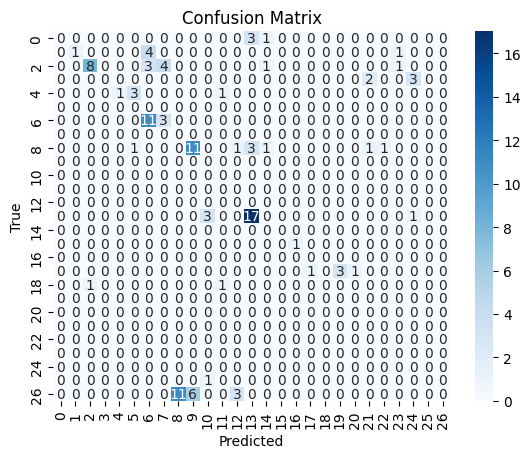

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Вычисление матрицы ошибок
cm = confusion_matrix(y_true, y_pred)

# Визуализация матрицы ошибок
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### CoT

In [114]:
class ClassifyResponse(BaseModel):
    category: str = Field(..., description="""Ответ в формате: КАТЕГОРИЯ""")

parser = PydanticOutputParser(pydantic_object=ClassifyResponse)

SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.
- Если в названии товарной позиции описывается действие, то это должна быть категория "Услуги"
- Любое програмное обеспечение считается услугами

Подумай шаг за шагом.

Правила для формирования ответа:
1. **Рассуждение должно быть текстовым.**  
   - Рассуждения должны быть представлены в виде сплошного текста. Блоки кода в ходе рассуждения запрещены.
   - Все логические шаги, анализы и выводы должны быть изложены четко и последовательно.
2. **Финальный ответ должен быть представлен в виде JSON-объекта, заключённого в один блок кода.**  
   - Финальный ответ должен быть корректным JSON-объектом, который заключается в один блок кода (используя три обратных апострофа ```).
   - Внутри JSON-объекта не должно быть дополнительных объяснений или текстовых комментариев.
3. **Фраза "Окончательный ответ" должна предварять блок кода с JSON-объектом.**  
   - Перед блоком кода с JSON-объектом должна быть написана фраза **"Окончательный ответ:"** (без кавычек в самой фразе).  
   - Между фразой и блоком кода не должно быть пустых строк.

Формат ответа должен соответствовать этому: {format_instructions}
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
""".strip()

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [115]:
batch = [{
    "categories": categories_txt,
    "problem_title": product["title"],
    "format_instructions": parser.get_format_instructions()
} for product in metrics_data]

In [116]:
chain = prompt | llm

results = chain.batch(batch)

# print(*[[product["title"], ans.content] for product, ans in zip(metrics_data, results)], sep="\n")



In [73]:
len([_ for _ in results if "Окончательный ответ:" in _.content])

120

In [80]:
for item in results:
    print(item.content)
    print()

Для классификации товара "Тетрадь школьная Комус Класс (№1 School) голубая А5 24 листа в клетку (10 штук в упаковке)" необходимо проанализировать ключевые слова в названии. 

1. Название начинается с "Тетрадь школьная", что сразу указывает на принадлежность к канцелярским товарам.
2. Дополнительные характеристики, такие как размер "А5", количество листов "24 листа" и тип бумаги "в клетку", также характерны для канцелярских товаров.
3. Упаковка "10 штук в упаковке" не меняет основную категорию товара.

На основании этих характеристик можно сделать вывод, что данный товар относится к категории "Канцелярские товары".

Окончательный ответ:
```json
{"category": "Канцелярские товары"}
```

Для классификации товара "Смазка CET CET2828" необходимо проанализировать его название. Слово "смазка" указывает на продукт, используемый для уменьшения трения между поверхностями, что обычно относится к техническим жидкостям или материалам. Такие продукты часто применяются в автомобильной и промышленной с

In [119]:
y_pred = [parser.invoke(item.content.split("Окончательный ответ:")[1]).category if parser.invoke(item.content.split("Окончательный ответ:")[1]).category in categories_array else "" for item in results]
y_pred

['Канцелярские товары',
 'Продукты химические прочие',
 'Компьютеры и периферийное оборудование',
 'Оборудование электрическое прочее',
 'Канцелярские товары',
 'Мебель',
 'Канцелярские товары',
 'Канцелярские товары',
 'Инструменты',
 'Мебель',
 'Канцелярские товары',
 'Канцелярские товары',
 'Автозапчасти',
 'Канцелярские товары',
 'Канцелярские товары',
 'Канцелярские товары',
 'Инструменты и оборудование',
 'Мебель',
 'Изделия из пластмасс',
 'Одежда',
 'Канцелярские товары',
 'Мебель',
 'Инструменты и оборудование',
 'Одежда',
 'Товары для дома',
 'Канцелярские товары',
 'Одежда',
 'Компьютеры и периферийное оборудование',
 'Канцелярские товары',
 'Техника бытовая электронная',
 'Техника бытовая электронная',
 'Изделия из пластмасс',
 'Компьютеры и периферийное оборудование',
 'Изделия из пластмасс',
 'Изделия из пластмасс',
 'Изделия из пластмасс',
 'Инструменты и оборудование',
 'Канцелярские товары',
 'Изделия из пластмасс',
 'Канцелярские товары',
 'Одежда',
 'Товары для дома'

Accuracy: 0.72


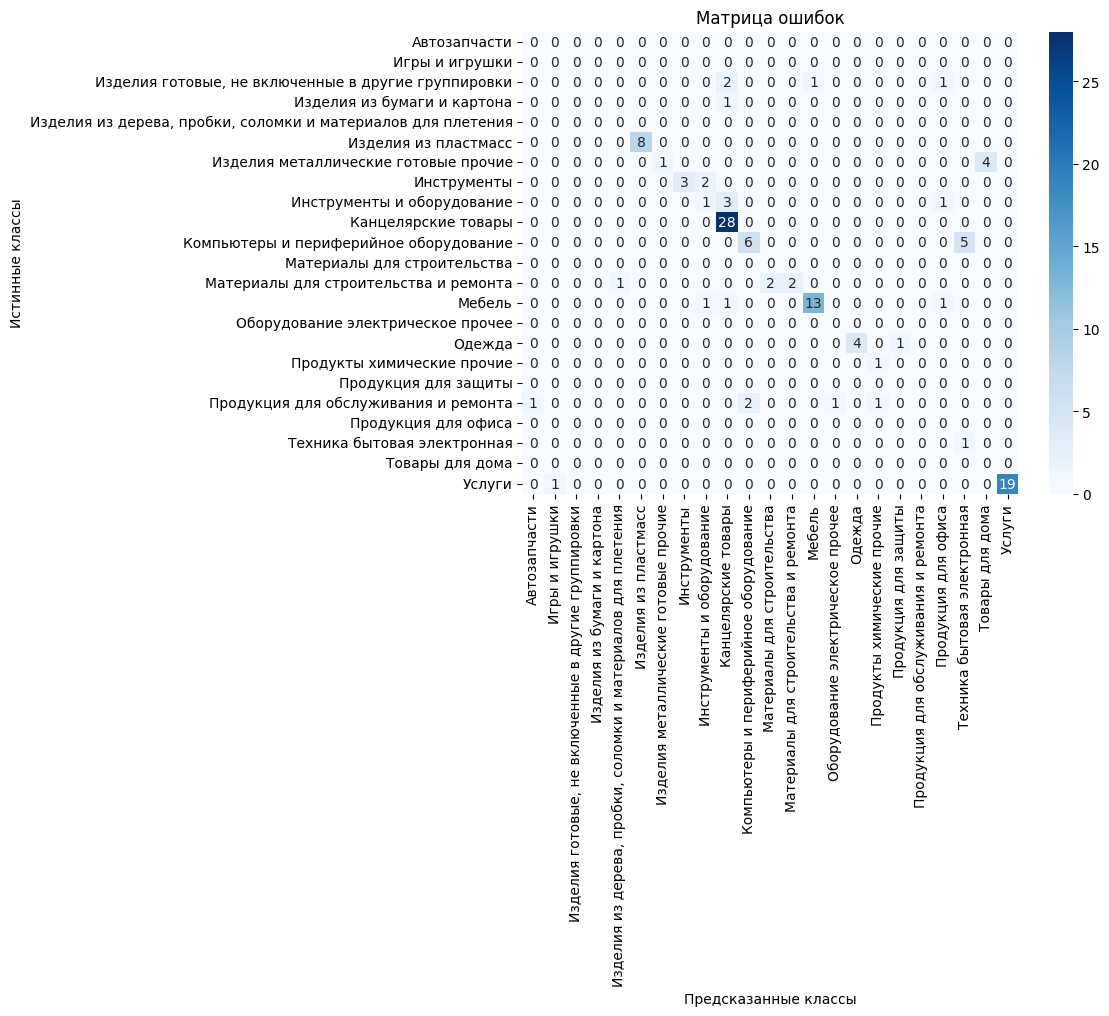

In [120]:
# Преобразование текстовых лейблов в числовые значения
label_encoder = LabelEncoder()

labels = set(y_true + y_pred)
label_encoder.fit_transform(list(labels))
y_true_encoded = label_encoder.transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)

# Получение уникальных названий классов
class_names = label_encoder.classes_

print(f"Accuracy: {accuracy_score(y_true_encoded, y_pred_encoded):.2f}")

# Визуализация матрицы ошибок с названиями категорий
plt.figure(figsize=(8, 6))  # Устанавливаем размер графика
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()

In [83]:
for item, true, pred in zip(metrics_data, y_true, y_pred):
    print(item["title"])
    print(true)
    print(pred)
    print()

Тетрадь школьная Комус Класс (№1 School) голубая А5 24 листа в клетку (10 штук в упаковке)
Канцелярские товары
Канцелярские товары

Смазка CET CET2828
Продукция для обслуживания и ремонта
Продукты химические прочие

Кулер для процессора DeepCool ICE EDGE Mini RET
Компьютеры и периферийное оборудование
Компьютеры и периферийное оборудование

Термистор CET CET531003
Продукция для обслуживания и ремонта
Оборудование электрическое прочее

Тетрадь школьная Альт Военный паттерн А5 24 листа в линейку (10 штук в упаковке)
Канцелярские товары
Канцелярские товары

Тумба приставная Metal System Style Б.ТП-1 (акация лорка, 412x720x750 мм)
Мебель
Мебель

Папка-планшет с зажимом Attache A4 пластиковая черная
Изделия из пластмасс
Канцелярские товары

Папка-конверт на молнии Attache А5 бесцветная 230 мкм (2 штуки в упаковке)
Изделия из пластмасс
Канцелярские товары

Уровень пузырьковый Matrix 3 глазка 1200 мм усиленный магнитный (34712)
Инструменты
Инструменты

Пуф Куба складной с ящиком для хранения 

## Подход 2

### Zero-shot

In [6]:
class ClassifyResponse(BaseModel):
    category: str = Field(..., description="""Ответ в формате: КАТЕГОРИЯ""")

parser = PydanticOutputParser(pydantic_object=ClassifyResponse)

SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия и вложенных категорий. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.
- Если в названии товарной позиции описывается действие, то это должна быть категория "Услуги"
- ПО считается услугой


Правила для формирования ответа:
1. **Финальный ответ должен быть представлен в виде JSON-объекта, заключённого в один блок кода.**  
   - Финальный ответ должен быть корректным JSON-объектом, который заключается в один блок кода (используя три обратных апострофа ```).
   - Внутри JSON-объекта не должно быть дополнительных объяснений или текстовых комментариев.
2. **Фраза "Окончательный ответ" должна предварять блок кода с JSON-объектом.**  
   - Перед блоком кода с JSON-объектом должна быть написана фраза **"Окончательный ответ:"** (без кавычек в самой фразе).  
   - Между фразой и блоком кода не должно быть пустых строк.

Формат ответа должен соответствовать этому: {format_instructions}
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
Вложенные категории: {problem_categories}
""".strip()

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [7]:
batch = [{
    "categories": categories_txt,
    "problem_title": product["title"],
    "problem_categories": product["categories"],
    "format_instructions": parser.get_format_instructions()
} for product in metrics_data]
chain = prompt | llm

results = chain.batch(batch)

# print(*[[product["title"], ans.content] for product, ans in zip(metrics_data, results)], sep="\n")

In [8]:
y_pred = [parser.invoke(item.content.split("Окончательный ответ:")[1]).category if parser.invoke(item.content.split("Окончательный ответ:")[1]).category in categories_array else ""  for item in results]
y_pred

['Канцелярские товары',
 'Продукция для обслуживания и ремонта',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Канцелярские товары',
 'Мебель',
 'Канцелярские товары',
 'Канцелярские товары',
 'Инструменты',
 'Мебель',
 'Канцелярские товары',
 'Канцелярские товары',
 'Компьютеры и периферийное оборудование',
 'Инструменты и оборудование',
 'Канцелярские товары',
 'Канцелярские товары',
 'Инструменты',
 'Мебель',
 'Изделия из пластмасс',
 'Одежда',
 'Канцелярские товары',
 'Мебель',
 'Канцелярские товары',
 'Одежда',
 '',
 'Инструменты и оборудование',
 'Одежда',
 'Компьютеры и периферийное оборудование',
 'Канцелярские товары',
 'Инструменты и оборудование',
 'Инструменты и оборудование',
 'Изделия из пластмасс',
 'Компьютеры и периферийное оборудование',
 'Изделия из пластмасс',
 'Изделия из пластмасс',
 'Изделия из пластмасс',
 'Инструменты',
 'Канцелярские товары',
 'Изделия из пластмасс',
 'Канцелярские товары',
 'Одежда',
 '',
 'Изделия из

Accuracy: 0.73


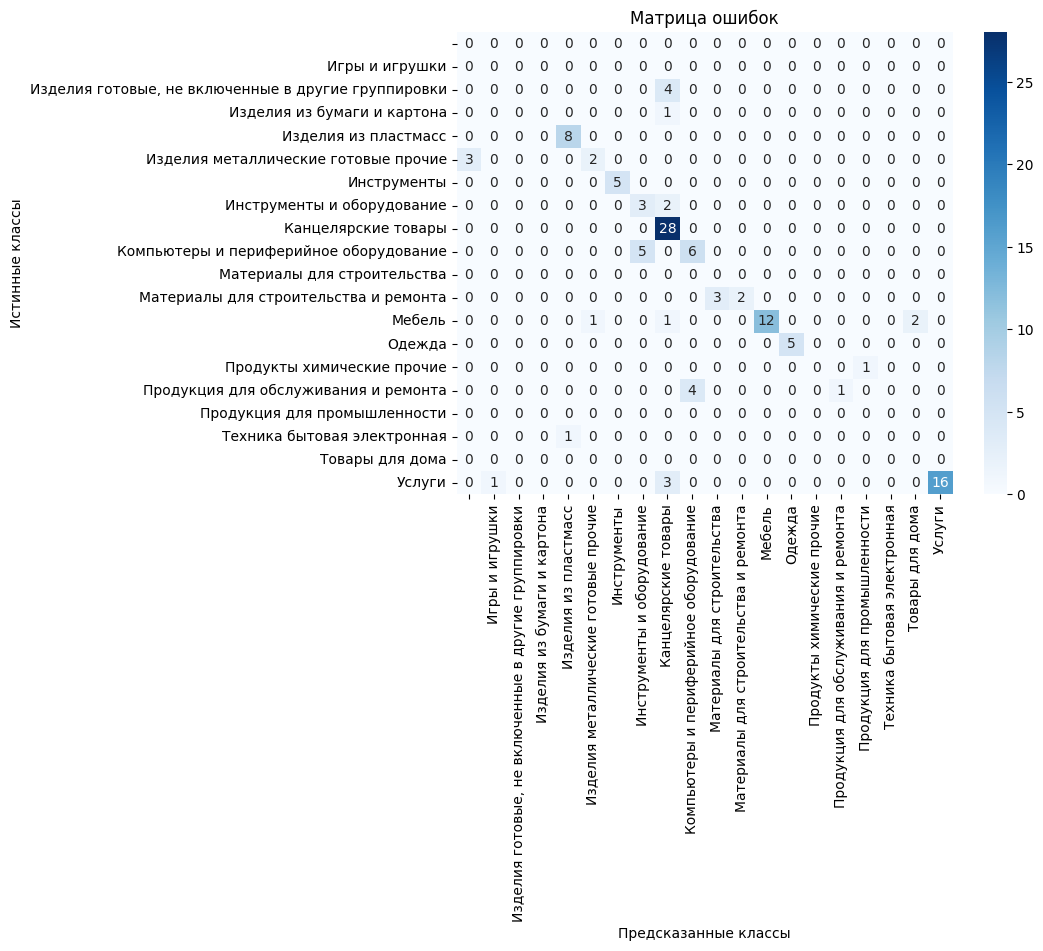

In [11]:
# Преобразование текстовых лейблов в числовые значения
label_encoder = LabelEncoder()

labels = set(y_true + y_pred)
label_encoder.fit_transform(list(labels))
y_true_encoded = label_encoder.transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)

# Получение уникальных названий классов
class_names = label_encoder.classes_

print(f"Accuracy: {accuracy_score(y_true_encoded, y_pred_encoded):.2f}")

# Визуализация матрицы ошибок с названиями категорий
plt.figure(figsize=(8, 6))  # Устанавливаем размер графика
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()

### CoT

In [91]:
class ClassifyResponse(BaseModel):
    category: str = Field(..., description="""Ответ в формате: КАТЕГОРИЯ""")

parser = PydanticOutputParser(pydantic_object=ClassifyResponse)

SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия и вложенных категорий. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.
- Если в названии товарной позиции описывается действие, то это должна быть категория "Услуги"
- ПО считается услугой

Подумай шаг за шагом.

Правила для формирования ответа:
1. **Рассуждение должно быть текстовым.**  
   - Рассуждения должны быть представлены в виде сплошного текста. Блоки кода в ходе рассуждения запрещены.
   - Все логические шаги, анализы и выводы должны быть изложены четко и последовательно.
2. **Финальный ответ должен быть представлен в виде JSON-объекта, заключённого в один блок кода.**  
   - Финальный ответ должен быть корректным JSON-объектом, который заключается в один блок кода (используя три обратных апострофа ```).
   - Внутри JSON-объекта не должно быть дополнительных объяснений или текстовых комментариев.
3. **Фраза "Окончательный ответ" должна предварять блок кода с JSON-объектом.**  
   - Перед блоком кода с JSON-объектом должна быть написана фраза **"Окончательный ответ:"** (без кавычек в самой фразе).  
   - Между фразой и блоком кода не должно быть пустых строк.

Формат ответа должен соответствовать этому: {format_instructions}
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
Вложенные категории: {problem_categories}
""".strip()

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [92]:
batch = [{
    "categories": categories_txt,
    "problem_title": product["title"],
    "problem_categories": product["categories"],
    "format_instructions": parser.get_format_instructions()
} for product in metrics_data]
chain = prompt | llm

results = chain.batch(batch)

# print(*[[product["title"], ans.content] for product, ans in zip(metrics_data, results)], sep="\n")

In [107]:
y_pred = [parser.invoke(item.content.split("Окончательный ответ:")[1]).category if parser.invoke(item.content.split("Окончательный ответ:")[1]).category in categories_array else ""  for item in results]
y_pred

['Канцелярские товары',
 'Продукция для обслуживания и ремонта',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Канцелярские товары',
 'Мебель',
 'Канцелярские товары',
 'Канцелярские товары',
 'Инструменты и оборудование',
 'Мебель',
 'Канцелярские товары',
 'Канцелярские товары',
 'Компьютеры и периферийное оборудование',
 'Канцелярские товары',
 'Канцелярские товары',
 'Оборудование электрическое прочее',
 'Инструменты',
 'Мебель',
 'Продукция для офиса',
 'Одежда',
 'Канцелярские товары',
 'Мебель',
 'Канцелярские товары',
 'Одежда',
 'Товары для дома',
 'Инструменты и оборудование',
 'Одежда',
 'Компьютеры и периферийное оборудование',
 'Канцелярские товары',
 'Инструменты и оборудование',
 'Инструменты и оборудование',
 'Продукция для офиса',
 'Компьютеры и периферийное оборудование',
 'Продукция для офиса',
 'Продукция для офиса',
 'Изделия из пластмасс',
 'Инструменты',
 'Канцелярские товары',
 'Продукция для офиса',
 'Канцелярские товар

Accuracy: 0.72


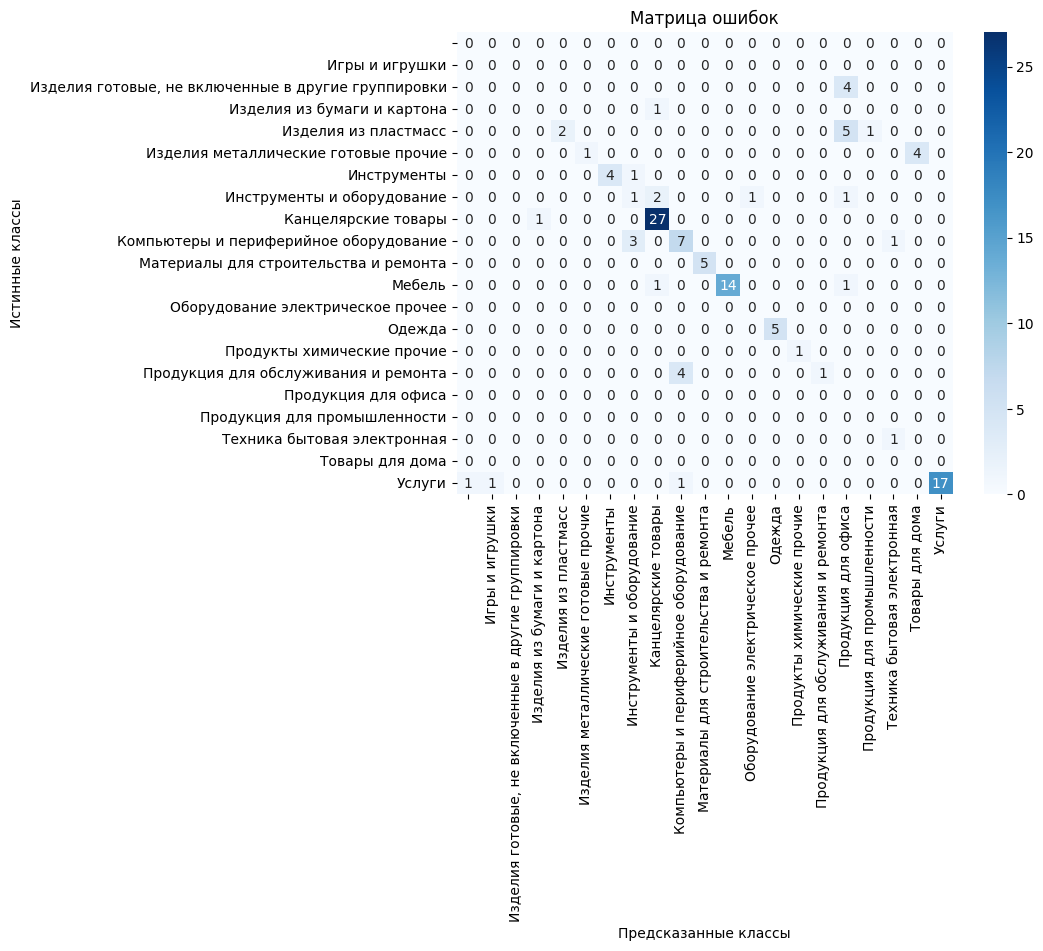

In [ ]:
# Преобразование текстовых лейблов в числовые значения
label_encoder = LabelEncoder()

labels = set(y_true + y_pred)
label_encoder.fit_transform(list(labels))
y_true_encoded = label_encoder.transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)

# Получение уникальных названий классов
class_names = label_encoder.classes_

print(f"Accuracy: {accuracy_score(y_true_encoded, y_pred_encoded):.2f}")

# Визуализация матрицы ошибок с названиями категорий
plt.figure(figsize=(8, 6))  # Устанавливаем размер графика
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()

In [104]:
for item, true, pred in zip(metrics_data, y_true, y_pred):
    print(item["title"])
    print(true)
    print(pred)
    print()

Тетрадь школьная Комус Класс (№1 School) голубая А5 24 листа в клетку (10 штук в упаковке)
Канцелярские товары
Канцелярские товары

Смазка CET CET2828
Продукция для обслуживания и ремонта
Продукция для обслуживания и ремонта

Кулер для процессора DeepCool ICE EDGE Mini RET
Компьютеры и периферийное оборудование
Компьютеры и периферийное оборудование

Термистор CET CET531003
Продукция для обслуживания и ремонта
Компьютеры и периферийное оборудование

Тетрадь школьная Альт Военный паттерн А5 24 листа в линейку (10 штук в упаковке)
Канцелярские товары
Канцелярские товары

Тумба приставная Metal System Style Б.ТП-1 (акация лорка, 412x720x750 мм)
Мебель
Мебель

Папка-планшет с зажимом Attache A4 пластиковая черная
Канцелярские товары
Канцелярские товары

Папка-конверт на молнии Attache А5 бесцветная 230 мкм (2 штуки в упаковке)
Канцелярские товары
Канцелярские товары

Уровень пузырьковый Matrix 3 глазка 1200 мм усиленный магнитный (34712)
Инструменты
Инструменты и оборудование

Пуф Куба скл

In [101]:
for item, ans in zip(results, y_true):
    print(item.content)
    print(f"Правильный ответ: {ans}")
    print()

Для классификации товара "Тетрадь школьная Комус Класс (№1 School) голубая А5 24 листа в клетку (10 штук в упаковке)" начнем с анализа его названия и вложенных категорий. 

1. Название товара содержит слово "тетрадь", что является ключевым индикатором канцелярского товара.
2. В названии указано, что это "школьная тетрадь", что дополнительно подтверждает принадлежность к канцелярским товарам, так как такие тетради обычно используются в образовательных учреждениях.
3. Вложенные категории также указывают на канцелярский характер товара: "Школьные тетради (12-24 листов)" и "Школьные блокноты и тетради".
4. Размер и количество листов (А5, 24 листа) не влияют на категорию, но подтверждают, что это стандартный канцелярский продукт.

На основании вышеизложенного, наиболее подходящей категорией для данного товара является "Канцелярские товары".

Окончательный ответ:
```json
{"category": "Канцелярские товары"}
```
Правильный ответ: Канцелярские товары

Для классификации товара "Смазка CET CET282